# Lab 04: Image Matching and Image Stitching

In this lab, you'll implement and play with the algorithms taught in course 5 and 6. 

- Student Name: 杨亿酬
- Student ID: 3230105697
- Date: 2025-10-27

---

## Part I: Image Matching

### Task 1: Find corners with harris detector

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

(448, 800)
uint8


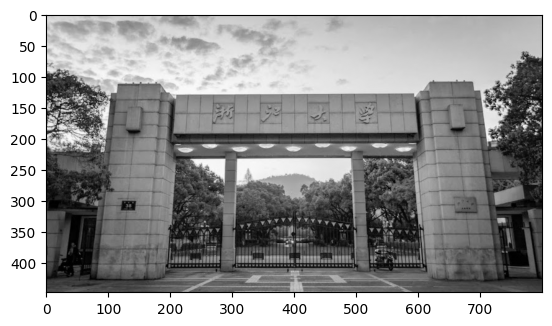

In [6]:
# Let's load an example image
filename = 'building.jpeg'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
fig = plt.imshow(img, cmap='gray')

print(img.shape)
print(img.dtype)
plt.show()

Step 1. Compute the covariance matrix at each point

$$H=\begin{bmatrix}I_x^2& I_xI_y\\I_xI_y &I_y^2\end{bmatrix}$$

where $I_x=\frac{\partial f}{\partial x}, I_y=\frac{\partial f}{\partial y}$.

In practice, we can further apply a 2D gaussian filter G to smooth H

$$ H'_{i,j,c} = \sum_{m=1}^{W} \sum_{n=1}^{W} G_{m,n} \cdot H_{i+m-\frac{W+1}{2},j+n-\frac{W+1}{2},c} $$

In [9]:
# normalize image to [0,1]
img_float = img.astype(np.float32) / 255.0

# use sobel operator at every location
# sobel_x = [[-1,0,1],[-2,0,2],[-1,0,1]] # x direction convolution kernel
# sobel_y = [[-1,-2,-1],[0,0,0],[1,2,1]] # y direction convolution kernel
sobel_x = cv2.Sobel(img_float, cv2.CV_32F, 1, 0, ksize=3) # output 32Float,first-order derivative of x,kernel size=3
sobel_y = cv2.Sobel(img_float, cv2.CV_32F, 0, 1, ksize=3) # padding automatically

# compute H 
H = np.zeros((img.shape[0], img.shape[1], 4)) # (448, 800, 4)
H[..., 0] = sobel_x ** 2 # H[:,:,0]
H[..., 1] = sobel_x * sobel_y
H[..., 2] = sobel_x * sobel_y
H[..., 3] = sobel_y ** 2

# gaussian weights, what window-size should be used?
window_size = 5 # 2 * np.ceil(3 * 0.5) + 1
gaussian_kernel_1d = cv2.getGaussianKernel(window_size, 0.5)
gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d.transpose())
H = cv2.filter2D(H, -1, gaussian_kernel_2d)

Step 2. Harris response

Theoretically, we can compute eigenvalues

$H=\begin{bmatrix}a&b\\c&d\end{bmatrix}\quad \lambda_\pm=\frac{1}{2}((a+d)\pm\sqrt{4bc+(a-d)^2})$

and then classify points using eigenvalues of H, like:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/harris_region.jpg" alt="drawing" width="200"/>

However, computing eigenvalues are expensive, so we use the following alternative:

$$f=\frac{\lambda_1 \lambda_2}{\lambda_1+\lambda_2}=\frac{determinant(H)}{trace(H)}$$

where $det(\begin{bmatrix}a&b\\c&d\end{bmatrix})=ad-bc$,   and $trace(\begin{bmatrix}a&b\\c&d\end{bmatrix})=a+d$

In [33]:
# compute harris response
f = np.zeros_like(img, dtype=np.float32)
det = H[..., 0] * H[..., 3] - H[..., 1] * H[..., 2]
trace = H[..., 0] + H[..., 3]
f = det / trace
#print(f)

/tmp/ipykernel_83385/2955322071.py:5: RuntimeWarning: invalid value encountered in divide
  f = det / trace


Step 3. Threshold $f$ and visualize

we skip non-maximum suppression operation here. You only need to visualize the thresholded harris response map.

corner_count=9457,density=0.02638671875


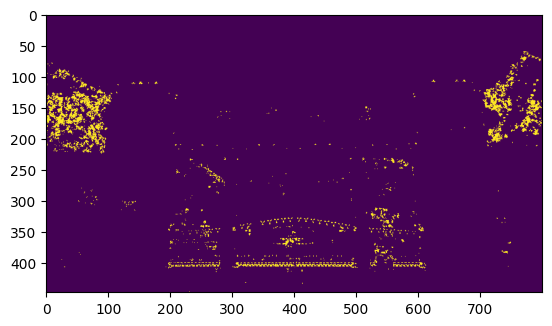

In [37]:
# threshold and visualize the binary response map with plt.imshow(f_binary)
# the threshold is a hyperparameter, try different values
threshold = 1e-1
f_binary = f > threshold

corner_count = np.sum(f_binary)
total_pixels = img.shape[0] * img.shape[1]
corner_density = corner_count / total_pixels
print(f"corner_count={corner_count},density={corner_density}")

plt.imshow(f_binary)
plt.show()

Further reading:

[【计算机视觉】2. 特征点检测：Harris, SIFT, SURF, ORB](https://zhuanlan.zhihu.com/p/36382429)

### Task 2: SIFT

To do this task, read [opencv documentation on SIFT](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html) first, and use it for local feature detection and description.

In [62]:
# load an image
img0 = cv2.imread("1.jpeg", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("2.jpeg", cv2.IMREAD_GRAYSCALE)

In [61]:
# create sift extractor (detector + descriptor)
SIFT = cv2.SIFT_create()

# get the detector and descriptor
kpts0, descs0 = SIFT.detectAndCompute(img0, mask=None)
kpts1, descs1 = SIFT.detectAndCompute(img1, mask=None)
# print(descs0)
#detect:DoG pyramid
#descriptor:oriented gradients

For SIFT descriptors, people usually match them with ratio-test.

(1) Please list the main advantage of ratio-test in matching SIFT descriptors.

(2) Do you think mutual-nearest-neighbor method can also work?

 <span style="color:white">
 
 (1) Ratio-test/ratio score is used for finding the best pairs and the ambiguity level by computing the division of best match distance and second match distance.The key idea is that the best matches are far better than the second best matching.The advantages of ratio-test including:  
 1.less ambiguity:the ratio-test is invented for coping with the challenge of incorrect matches.These incorrect matches happen mainly because of repetition(ambiguity).However,the ratio test can find ambiguous matches easily since they have large ratio scores.  
 2.robustness:by selecting a proper ratio,it can still find proper matches despite noises or image distortion.  
 3.adaptivity:can work on different image pairs regardless of the distance between the pixels.

 (2) Yes,mutual-nearest-neighbor method can also work well in matching SIFT descriptors.  
 Mutual-nearest-neighbor method(MNN) is to find f1 in image1(I1) and f2 in I2,such that f2 is the nearest neighbor of f1 in I2,and f1 is the nearest neighbor of f2 in I1.  
 Using MNN,descriptor matches can be much more accurate,because the result(descriptor) is validated on both images.
 
 </span>


In [58]:
# compute descriptor distance
distance = np.zeros((descs0.shape[0], descs1.shape[0]))
for i in range(descs0.shape[0]):
    for j in range(descs1.shape[0]):
        distance[i][j] = np.linalg.norm(descs0[i] - descs1[j])

# ratio test
mkpts0 = []
mkpts1 = []
ratio_threshold = 0.7
for i in range(descs0.shape[0]):
    min_distance = float('inf')     
    second_min_distance = float('inf')  
    best_match_idx = -1            
    for j in range(descs1.shape[0]):
        # find the smallest and second-smallest distance
        cur_dis = distance[i][j]
        if cur_dis < min_distance:
            second_min_distance = min_distance 
            min_distance = cur_dis   
            # record the index of the smallest distance
            best_match_idx = j               
        elif cur_dis < second_min_distance:
            second_min_distance = cur_dis

    ratio_score = min_distance / second_min_distance
    # compare the division with ratio_threshold
    if ratio_score < ratio_threshold:
        mkpts0.append(kpts0[i].pt)
        mkpts1.append(kpts1[best_match_idx].pt)

mkpts0 = np.array(mkpts0)
mkpts1 = np.array(mkpts1)

And visualize the final matches.

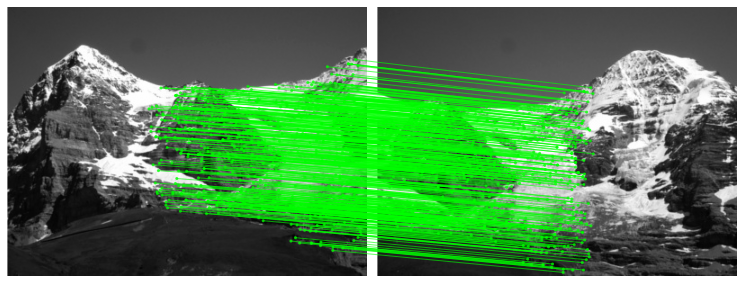

In [59]:
# visualization
# You might need to read the documentation of this function. Or you can write your own drawing function.
from utils import make_matching_figure

fig = make_matching_figure(img0, img1, mkpts0, mkpts1)
fig

---

## Part II: Image Stitching

One application for image matching is to stitch multiple images and get one panorama.

### Task 3: Transformation

Considering 2 images as input, you can use SIFT (provided by cv2) to find the transformation between them (implement it on your own).

In [11]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# load images
img0_rgb = cv2.imread("1.jpeg", cv2.IMREAD_COLOR)[..., [2, 1, 0]]
img1_rgb = cv2.imread("2.jpeg", cv2.IMREAD_COLOR)[..., [2, 1, 0]]
img0_gray = cv2.cvtColor(img0_rgb, cv2.COLOR_RGB2GRAY)
img1_gray = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)

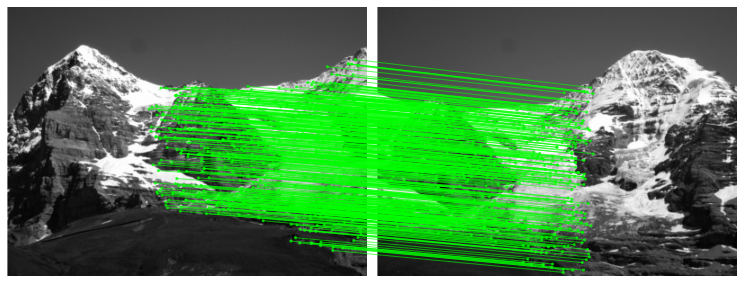

In [13]:
# compute SIFT keypoints and descriptors
# note: on gray image
SIFT = cv2.SIFT_create()

kpts0, descs0 = SIFT.detectAndCompute(img0_gray, None)
kpts1, descs1 = SIFT.detectAndCompute(img1_gray, None)

# use BFMatcher and knnMatch for a simpler implementation
bf = cv2.BFMatcher(cv2.NORM_L2) # L2 distance
matches = bf.knnMatch(descs0, descs1, k=2)
good_matches = []
ratio_threshold = 0.7

for match in matches:
    if len(match) == 2:  
        m, n = match # m for best match, n for second-best match
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)
# find matches
mkpts0 = np.array([kpts0[m.queryIdx].pt for m in good_matches])
mkpts1 = np.array([kpts1[m.trainIdx].pt for m in good_matches])

from utils import make_matching_figure

fig = make_matching_figure(img0_gray, img1_gray, mkpts0, mkpts1)
fig

Here, the transformation $H$ is defined as 
$$\begin{bmatrix}x_0\\y_0\\1\end{bmatrix}=\begin{bmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\0&0&1\end{bmatrix}\begin{bmatrix}x_1\\y_1\\1\end{bmatrix}$$

Please answer:

(1) What type is this transformation?

(2) Please write down the converted equation in the form of $Ah=b$. To solve this equation, what's the minimal number of matches we need? 

 <span style="color:white">
 
 (1) Affine transformation  
 
 (2) 
 $$
\begin{bmatrix}x_1 & y_1 & 1 & 0 & 0 & 0 \\ 0& 0 & 0 & x_1 & y_1 & 1\end{bmatrix}\begin{bmatrix}h_{11} \\ h_{12} \\ h_{13} \\ h_{21} \\ h_{22} \\ h_{23}\end{bmatrix}=\begin{bmatrix}x_0\\ y_0\end{bmatrix}
 $$
  
 Since there're 6 free variables and every match generates two functions,the minimal number of matches needed is 3.
 </span>


In [ ]:
# randomly select K matches (according to your answer)
random_indices = np.random.choice(len(mkpts0), size=3, replace=False)
selected_mkpts0 = mkpts0[random_indices]
selected_mkpts1 = mkpts1[random_indices] # choose the correspond mkpts1

# solve the equation
A = np.zeros((6,6))
b = np.zeros(6)
for i in range(3):
    x0, y0 = selected_mkpts0[i]
    x1, y1 = selected_mkpts1[i]
    A[2*i, 0] = x0
    A[2*i, 1] = y0  
    A[2*i, 2] = 1
    b[2*i] = x1
    A[2*i+1, 3] = x0
    A[2*i+1, 4] = y0
    A[2*i+1, 5] = 1
    b[2*i+1] = y1
h = np.linalg.solve(A, b)
# print(h)

[ 9.72049748e-01 -4.79989218e-02 -1.33485963e+02  5.06478580e-02
  9.85691576e-01  1.08877853e+01]


### Task 4: RANSAC

To use naive ransac algorithm, we need $N$ sample-points(样本点), to solve the model, we need $K$ sample-points as a minimal requirement. Then perform:

1. Randomly sample $K$ sample-points.
2. Fit the model with $K$ sample-points. Denoted as $\hat h$.
3. Compute error of other sample points according to $\hat h$. Count the inliers within some threshold.
4. Repeat $M$ times, the final $h$ is the $\hat h$ with most inliers. 

In [47]:
# implement your own RANSAC
def ransac_to_estimate_H(samples, K, inlier_thr, M): 
    H = 0 
    max_inlier_cnt = 0
    mkpts0 = samples[0]
    mkpts1 = samples[1]
    # 4.repeat M times
    for i in range(M):
        # 1.randomly sample K points
        random_indices = np.random.choice(len(mkpts0), size=K, replace=False)
        selected_mkpts0 = mkpts0[random_indices]
        selected_mkpts1 = mkpts1[random_indices]
        # 2.fit the model with K points to get h
        A = np.zeros((2*K,9))
        for j in range(K):
            x0, y0 = selected_mkpts0[j]
            x1, y1 = selected_mkpts1[j]
            A[2*j, 0] = x0
            A[2*j, 1] = y0  
            A[2*j, 2] = 1
            A[2*j, 6] = -x0 * x1
            A[2*j, 7] = -y0 * x1
            A[2*j, 8] = -x1
            A[2*j+1, 3] = x0
            A[2*j+1, 4] = y0
            A[2*j+1, 5] = 1
            A[2*j+1, 6] = -y1 * x0
            A[2*j+1, 7] = -y1 * y0
            A[2*j+1, 8] = -y1

        U, S, Vt = np.linalg.svd(A)
        h = Vt[-1: ] # the smallest eigenvalue of A.T @ T
        h = h.reshape(3, 3)
        # 3.compute error of other sample points to h,count inliers within threshold
        inlier_cnt = 0
        for idx in range(len(mkpts0)):
            if idx in random_indices:
                continue # skip the samples already used
            x0, y0 = mkpts0[idx]
            x1, y1 = mkpts1[idx]
            
            h_transform = h @ np.array([x0, y0, 1.0])
            x1_pred = h_transform[0] / h_transform[2]
            y1_pred = h_transform[1] / h_transform[2]

            error = np.sqrt((x1_pred - x1)**2 + (y1_pred - y1)**2)
            if error <= inlier_thr:
                inlier_cnt += 1
        if inlier_cnt > max_inlier_cnt:
            H = h
            inlier_cnt = max_inlier_cnt
    return H
H = ransac_to_estimate_H(samples=(mkpts0,mkpts1),K=4,inlier_thr=3,M=1000)
print(H)

[[ 6.87908214e-03 -3.66979424e-04 -9.98930399e-01]
 [ 6.22488375e-04  6.73490859e-03 -4.48230237e-02]
 [ 1.83430490e-06  6.15327709e-07  5.97933361e-03]]


In [48]:
# use cv2.warpPerspective to put one image on the other
height, width, channels = img1_rgb.shape
dsize = (width * 2, height)
panorama = cv2.warpPerspective(img0_rgb, H, dsize)
panorama[:, :width] = img1_rgb

# use plt to visualize the results
plt.imshow(panorama[..., [2, 1, 0]])

How to solve the artifacts in the overlapping region? Name 2 possible methods.

 <span style="color:white">
 
 1.weighted average blending based on the distance to the seam  
 2.optimal seam finding(graph cut)  
 3.deep-learning  
 
 
 </span>
